# Time Series

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from jupyterthemes import jtplot
jtplot.style(figsize=(15, 9))

## Data review

In [2]:
bac_df = pd.read_csv('../data/order_book/BAC_24_04.csv', index_col=[0], parse_dates=True)
bac_df

,Bid,Ask,Last,Volume,Type
Time,,,,,
2023-04-24 13:58:43.114,29.74,29.74,29.74,162.0,Buy
2023-04-24 13:58:43.167,29.73,29.74,29.74,503.0,Buy
2023-04-24 13:58:43.167,29.73,29.74,29.74,197.0,Buy
2023-04-24 13:58:43.567,29.73,29.74,29.74,200.0,Buy
2023-04-24 13:58:44.873,29.73,29.74,29.74,2000.0,Buy
...,...,...,...,...,...
2023-04-24 14:02:34.435,29.69,29.70,29.69,530.0,Sell
2023-04-24 14:02:42.038,29.69,29.70,29.70,100.0,Buy
2023-04-24 14:02:42.038,29.69,29.70,29.70,200.0,Buy


In [3]:
bk_df = pd.read_csv('../data/order_book/BK_24_04.csv', index_col=[0], parse_dates=True)
bk_df

,Bid,Ask,Last,Volume,Type
Time,,,,,
2023-04-24 13:46:02.843,44.02,44.03,44.03,100.0,Buy
2023-04-24 13:46:02.843,44.02,44.03,44.03,100.0,Buy
2023-04-24 13:46:04.876,44.01,44.02,44.02,100.0,Buy
2023-04-24 13:46:04.876,44.01,44.02,44.02,100.0,Buy
2023-04-24 13:46:04.876,44.01,44.02,44.02,100.0,Buy
...,...,...,...,...,...
2023-04-24 14:03:00.814,43.93,43.94,43.93,100.0,Sell
2023-04-24 14:03:01.235,43.93,43.94,43.93,100.0,Sell
2023-04-24 14:03:06.862,43.93,43.94,43.94,100.0,Buy


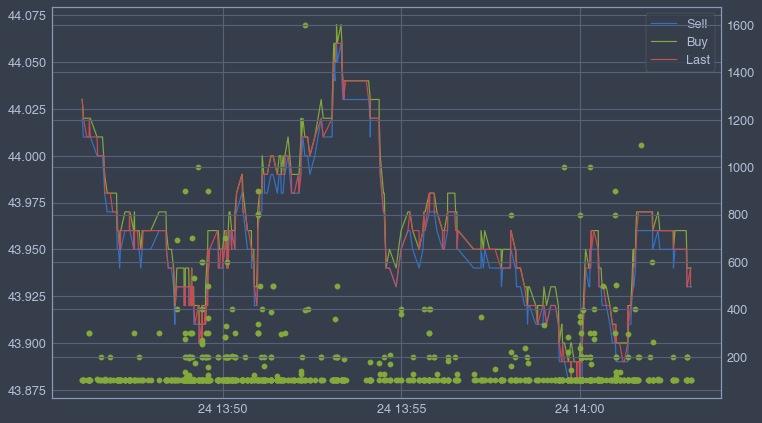

In [20]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(bk_df.index, bk_df['Bid'], label='Sell')
ax.plot(bk_df.index, bk_df['Ask'], label='Buy')
ax.plot(bk_df.index, bk_df['Last'], label='Last')
ax2.scatter(bk_df.index, bk_df['Volume'], label='Volume', c='g')
ax.grid(True)
ax.legend()

In [5]:
bk_df['Volume'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
Volume,1000.0,140.965,127.969395,100.0,100.0,100.0,100.0,1602.0


In [6]:
bk_df.loc['2023-04-24 13:52:18.427'].iloc[1]

Bid         44.0
Ask        44.01
Last       44.01
Volume    1602.0
Type         Buy
Name: 2023-04-24 13:52:18.427000, dtype: object

In [7]:
bk_df[bk_df['Volume'] == 800]

,Bid,Ask,Last,Volume,Type
Time,,,,,
2023-04-24 13:50:58.133,43.94,43.95,43.94,800.0,Sell
2023-04-24 13:58:04.116,43.95,43.96,43.96,800.0,Buy
2023-04-24 14:00:00.032,43.88,43.89,43.88,800.0,Sell
2023-04-24 14:01:00.236,43.90,43.91,43.90,800.0,Sell


In [8]:
bk_df[bk_df['Volume'] == bk_df['Volume'].max()]

,Bid,Ask,Last,Volume,Type
Time,,,,,
2023-04-24 13:52:18.427,44.0,44.01,44.01,1602.0,Buy


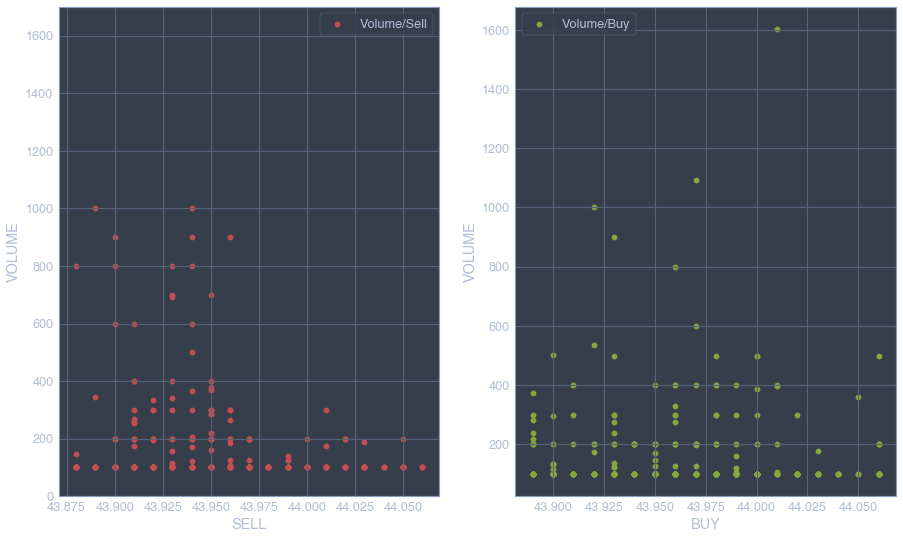

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9))

ax1.scatter(bk_df[bk_df['Type'] == 'Sell']['Last'], bk_df[bk_df['Type'] == 'Sell']['Volume'], label='Volume/Sell', c='r')
ax1.set_ylim(0, 1700)
ax1.set_xlabel('SELL')
ax1.set_ylabel('VOLUME');
ax1.legend()

ax2.scatter(bk_df[bk_df['Type'] == 'Buy']['Last'], bk_df[bk_df['Type'] == 'Buy']['Volume'], label='Volume/Buy', c='g')
ax1.set_ylim(0, 1700)
ax2.set_xlabel('BUY')
ax2.set_ylabel('VOLUME');
ax2.legend()

(array([ 59.,  45., 102.,  79.,  86.,  61.,  18.,  31.,  14.,  16.]),
 array([43.89 , 43.907, 43.924, 43.941, 43.958, 43.975, 43.992, 44.009,
        44.026, 44.043, 44.06 ]),
 <BarContainer object of 10 artists>)

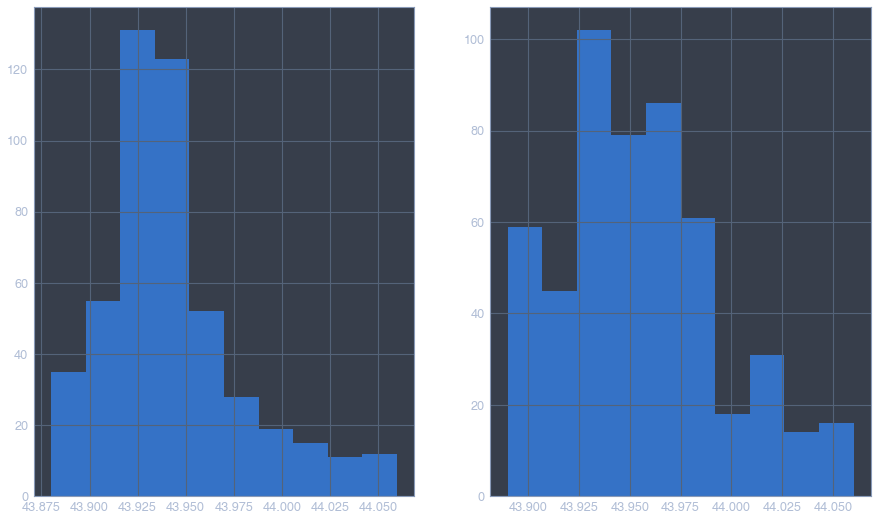

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9))
sell = bk_df[bk_df['Type'] == 'Sell']['Last']
ax1.hist(sell)

buy = bk_df[bk_df['Type'] == 'Buy']['Last']
ax2.hist(buy)

(array([1., 0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 5., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1.]),
 array([43.88 , 43.882, 43.884, 43.886, 43.888, 43.89 , 43.892, 43.894,
        43.896, 43.898, 43.9  , 43.902, 43.904, 43.906, 43.908, 43.91 ,
        43.912, 43.914, 43.916, 43.918, 43.92 , 43.922, 43.924, 43.926,
        43.928, 43.93 , 43.932, 43.934, 43.936, 43.938, 43.94 , 43.942,
        43.944, 43.946, 43.948, 43.95 , 43.952, 43.954, 43.956, 43.958,
        43.96 ]),
 <BarContainer object of 40 artists>)

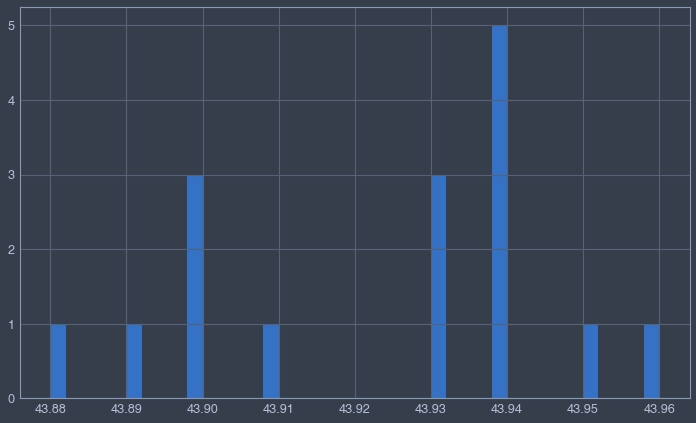

In [21]:
fig, ax = plt.subplots()
sell = bk_df[bk_df['Type'] == 'Sell'][bk_df[bk_df['Type'] == 'Sell']['Volume'] > 400]['Last']
ax.hist(sell, bins=40)

In [12]:
bk_df[bk_df['Type'] == 'Sell'][bk_df[bk_df['Type'] == 'Sell']['Volume'] > 400]

,Bid,Ask,Last,Volume,Type
Time,,,,,
2023-04-24 13:48:42.141,43.93,43.94,43.93,691.0,Sell
2023-04-24 13:49:07.010,43.93,43.94,43.93,700.0,Sell
2023-04-24 13:49:24.389,43.91,43.92,43.90,600.0,Sell
2023-04-24 13:49:24.389,43.91,43.92,43.91,600.0,Sell
2023-04-24 13:49:33.934,43.94,43.95,43.94,900.0,Sell
2023-04-24 13:49:33.934,43.94,43.95,43.94,500.0,Sell
2023-04-24 13:50:02.394,43.95,43.96,43.95,700.0,Sell
2023-04-24 13:50:06.856,43.94,43.95,43.94,600.0,Sell
2023-04-24 13:50:58.133,43.94,43.95,43.93,801.0,Sell


In [13]:
bk_df[bk_df['Type'] == 'Buy'][bk_df[bk_df['Type'] == 'Buy']['Volume'] > 400]

,Bid,Ask,Last,Volume,Type
Time,,,,,
2023-04-24 13:48:56.350,43.92,43.93,43.93,900.0,Buy
2023-04-24 13:49:10.777,43.91,43.92,43.92,534.0,Buy
2023-04-24 13:49:18.217,43.91,43.92,43.92,1000.0,Buy
2023-04-24 13:51:01.688,43.97,43.98,43.98,500.0,Buy
2023-04-24 13:51:24.024,43.99,44.00,44.00,500.0,Buy
2023-04-24 13:51:24.024,43.99,44.00,44.00,500.0,Buy
2023-04-24 13:52:18.427,44.00,44.01,44.01,1602.0,Buy
2023-04-24 13:53:10.900,44.05,44.06,44.06,500.0,Buy
2023-04-24 13:58:04.116,43.95,43.96,43.96,800.0,Buy


In [14]:
last_mean = bk_df['Last'].rolling(window=50).mean().dropna()
last_std = bk_df['Last'].rolling(window=50).std().dropna()
last_std

Time
2023-04-24 13:47:04.068    0.022084
2023-04-24 13:47:04.068    0.022348
2023-04-24 13:47:05.835    0.022896
2023-04-24 13:47:07.052    0.023579
2023-04-24 13:47:07.052    0.024159
                             ...   
2023-04-24 14:03:00.814    0.010422
2023-04-24 14:03:01.235    0.010835
2023-04-24 14:03:06.862    0.011045
2023-04-24 14:03:06.862    0.011622
2023-04-24 14:03:07.628    0.012157
Name: Last, Length: 951, dtype: float64

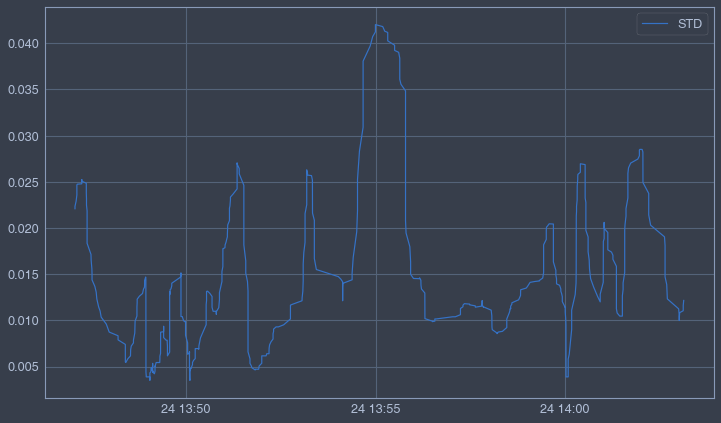

In [22]:
fig, ax = plt.subplots()
# ax.plot(bk_df.index, bk_df['Last'], label='Last', c='r')
# ax.plot(last_mean.index, last_mean, label='Mean', c='g')
ax.plot(last_std.index, last_std, label='STD')
ax.grid(True)
ax.legend()

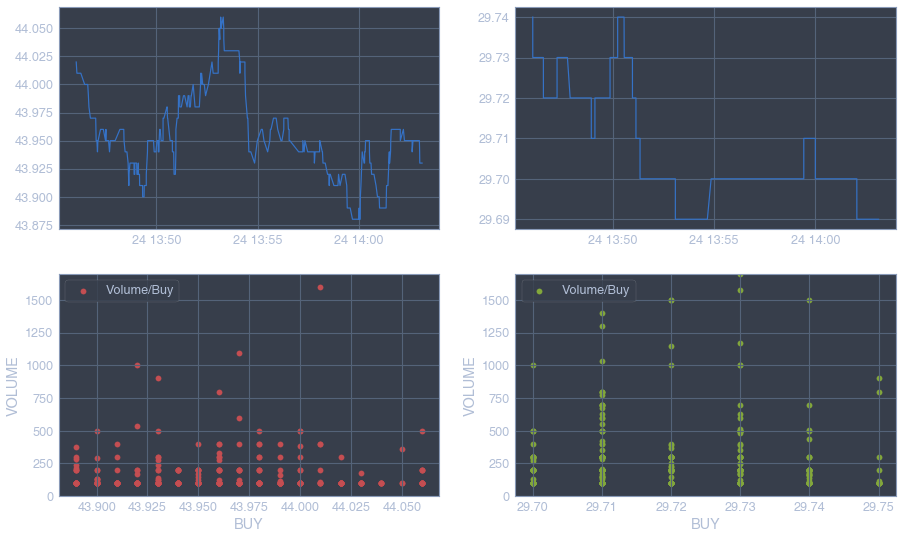

In [16]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 9))
ax1.plot(bk_df.index, bk_df['Bid'], label='BK bid')
ax2.plot(bk_df.index, bac_df['Bid'], label='BAC bid')

ax3.scatter(bk_df[bk_df['Type'] == 'Buy']['Last'], bk_df[bk_df['Type'] == 'Buy']['Volume'], label='Volume/Buy', c='r')
ax3.set_ylim(0, 1700)
ax3.set_xlabel('BUY')
ax3.set_ylabel('VOLUME');
ax3.legend()

ax4.scatter(bac_df[bac_df['Type'] == 'Buy']['Last'], bac_df[bac_df['Type'] == 'Buy']['Volume'], label='Volume/Buy', c='g')
ax4.set_ylim(0, 1700)
ax4.set_xlabel('BUY')
ax4.set_ylabel('VOLUME');
ax4.legend()

## Decomposition

BK bid price decomposition:


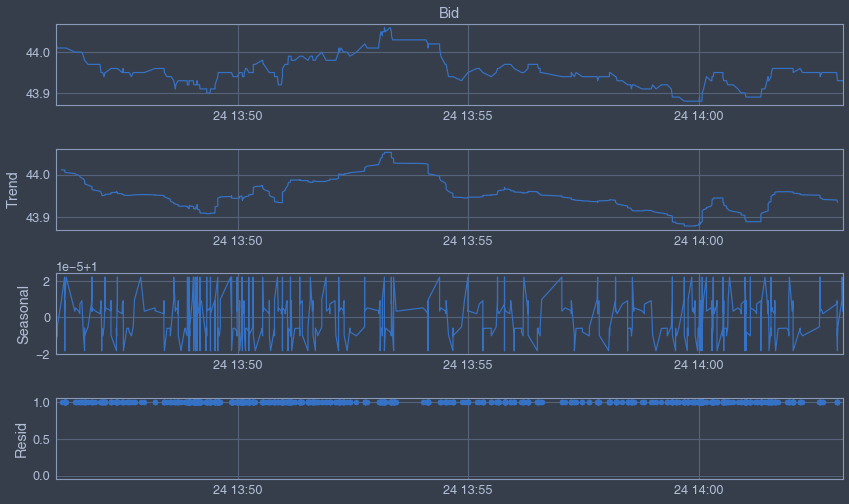

In [23]:
decomposition = sm.tsa.seasonal_decompose(bk_df['Bid'], period=15, model='multiplicative') 
figure = decomposition.plot()
print('BK bid price decomposition:')

BAC bid price decomposition:


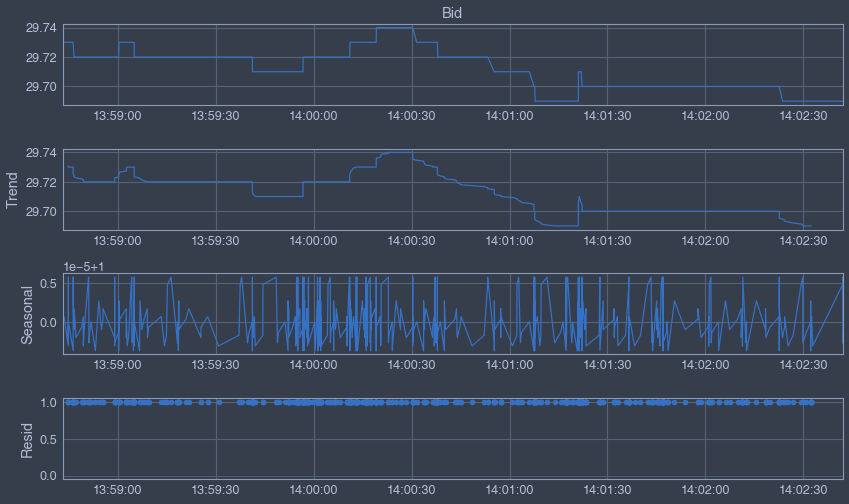

In [24]:
decomposition = sm.tsa.seasonal_decompose(bac_df['Bid'], period=15, model='multiplicative') 
figure = decomposition.plot()
print('BAC bid price decomposition:')

## Autocorrelation and Partial Autocorrelation

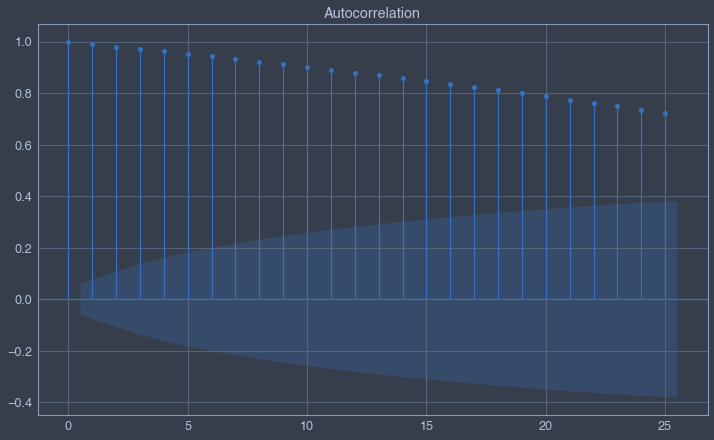

In [34]:
plot_acf(bk_df['Bid'], lags = 25);

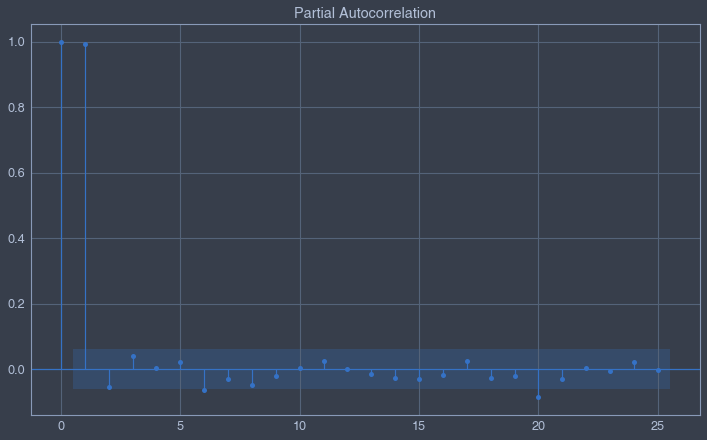

In [35]:
plot_pacf(bk_df['Bid'], lags = 25);

In [77]:
def show_adf_result(result):
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    print('******************************')


# def adf_for_decomposed_ts(ts):
#     decomposition = sm.tsa.seasonal_decompose(ts, period=15, model='multiplicative')
    
#     result_full_ts   = adfuller(ts)
#     show_adf_result(result_full_ts)
    
#     result_trend     = adfuller(decomposition.trend)
#     show_adf_result(result_trend)
    
#     result_seasonal  = adfuller(decomposition.seasonal)
#     show_adf_result(result_seasonal)
    
#     result_residuals = adfuller(decomposition.resid)
#     show_adf_result(result_residuals)

## Stationarity tests

### Agumented Dicky - Fuller Test

In [17]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(bk_df['Last'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -2.519467
p-value                          0.110809
#Lags Used                       6.000000
Number of Observations Used    993.000000
Critical Value (1%)             -3.436953
Critical Value (5%)             -2.864455
Critical Value (10%)            -2.568322
dtype: float64


In [20]:
bk_log_scale = np.log(bk_df['Last'])
bk_log_scale.head()

Time
2023-04-24 13:46:02.843    3.784871
2023-04-24 13:46:02.843    3.784871
2023-04-24 13:46:04.876    3.784644
2023-04-24 13:46:04.876    3.784644
2023-04-24 13:46:04.876    3.784644
Name: Last, dtype: float64

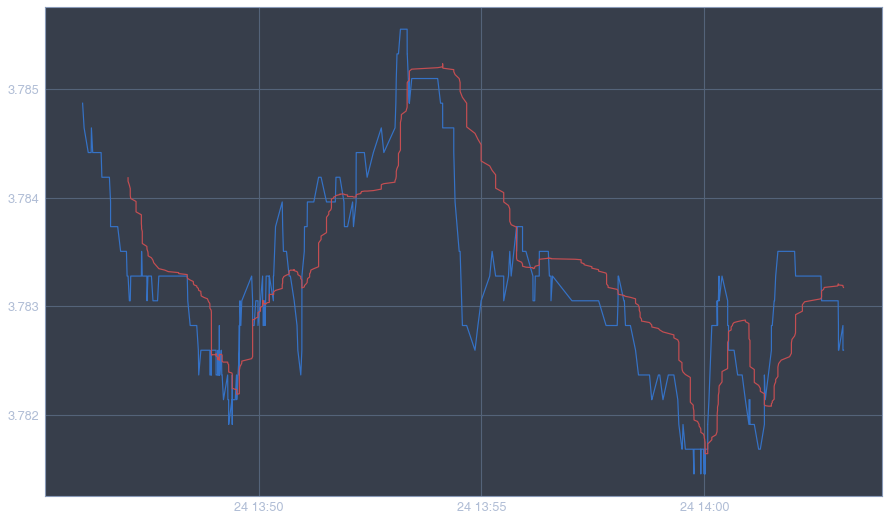

In [21]:
mov_average = bk_log_scale.rolling(window=50).mean()
mov_STD = bk_log_scale.rolling(window=50).std()
plt.plot(bk_log_scale)
plt.plot(mov_average, c='r')

In [22]:
dataset_bk_log_scale_minus_mov_average = bk_log_scale - mov_average

dataset_bk_log_scale_minus_mov_average.dropna(inplace=True)
dataset_bk_log_scale_minus_mov_average.head()

Time
2023-04-24 13:47:04.068   -0.000905
2023-04-24 13:47:04.068   -0.000873
2023-04-24 13:47:05.835   -0.001064
2023-04-24 13:47:07.052   -0.001032
2023-04-24 13:47:07.052   -0.001000
Name: Last, dtype: float64

### Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

In [16]:
def test_stationarity_KPSS(timeseries):
    dftest=kpss(timeseries, regression='c', nlags='auto')
    print(dftest)
    print('Results of Kwiatkowski–Phillips–Schmidt–Shin Test:')
    dfoutput = pd.Series(dftest[0:3],index=['Test Statistic', 'p-value', '#Lags Used'])
    for key,value in dftest[3].items():
        dfoutput['Critical Value (%s)' % key] = value
    print (dfoutput)

In [18]:
test_stationarity_KPSS(bac_df['Last'])

(2.881724392495955, 0.01, 19, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
Results of Kwiatkowski–Phillips–Schmidt–Shin Test:
Test Statistic            2.881724
p-value                   0.010000
#Lags Used               19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


f:\python\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [17]:
test_stationarity_KPSS(bk_df['Last'])

(0.49272918220687106, 0.043304238241695714, 19, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
Results of Kwiatkowski–Phillips–Schmidt–Shin Test:
Test Statistic            0.492729
p-value                   0.043304
#Lags Used               19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


## Research

### Test Stationary Function

In [9]:
def test_stationary(timeseries):
    ts_average = timeseries.rolling(window=50).mean()
    ts_STD = timeseries.rolling(window=50).std()
    
    orig = plt.plot(timeseries, c='b', label='Original')
    mean = plt.plot(ts_average, c='r', label='Rolling Mean')
    std = plt.plot(ts_STD, c='g', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput[f'Critical Value {key}'] = value
    
    if dftest[0] < dftest[4]['5%']:
        dfoutput['RESULT: '] = 'Reject Ho - Time Series is Stationary'
    else:
        dfoutput['RESULT: '] = 'Failed to Reject Ho - Time Series is Non-Stationary'

    print(dfoutput)

### Test Data

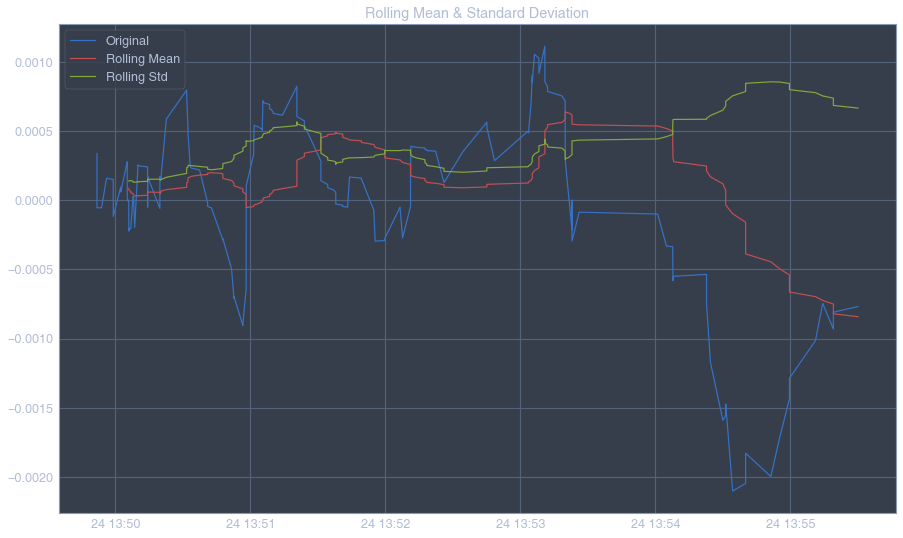

Results of Dickey-Fuller Test:
Test Statistic                                                         -2.493965
p-value                                                                  0.11695
#Lags Used                                                                   6.0
Number of Observations Used                                                293.0
Critical Value 1%                                                      -3.452867
Critical Value 5%                                                      -2.871455
Critical Value 10%                                                     -2.572053
RESULT:                        Failed to Reject Ho - Time Series is Non-Stati...
dtype: object


In [59]:
test_stationary(dataset_bk_log_scale_minus_mov_average[300:600])

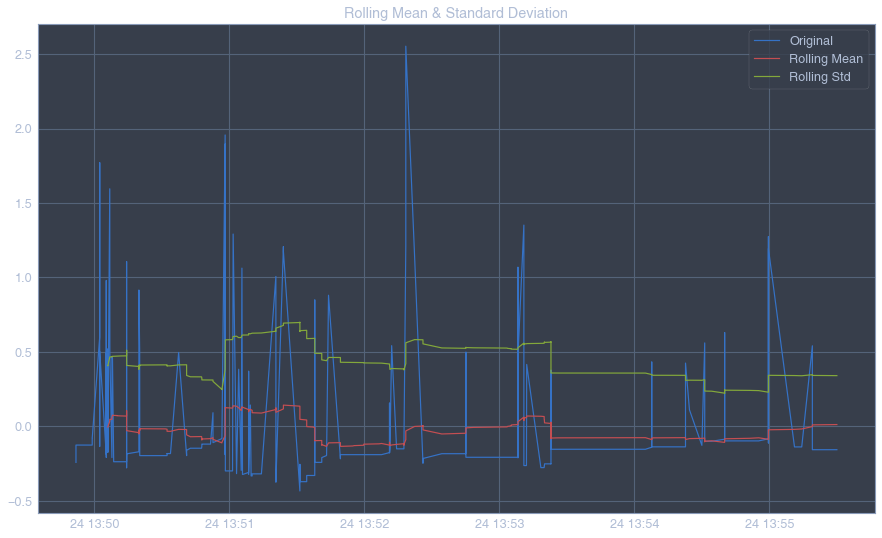

Results of Dickey-Fuller Test:
Test Statistic                                             -6.008726
p-value                                                          0.0
#Lags Used                                                       4.0
Number of Observations Used                                    295.0
Critical Value 1%                                          -3.452713
Critical Value 5%                                          -2.871388
Critical Value 10%                                         -2.572017
RESULT:                        Reject Ho - Time Series is Stationary
dtype: object


In [61]:
bk_log_scale_volume = np.log(bk_df['Volume'])
mov_average = bk_log_scale_volume.rolling(window=50).mean()
data = bk_log_scale_volume - mov_average
data.dropna(inplace=True)

test_stationary(data[300:600])

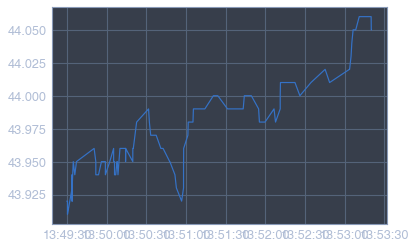

In [5]:
plt.plot(bk_df['Last'][300:600])

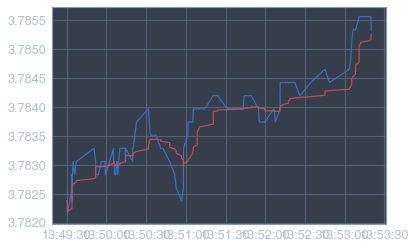

In [7]:
bk_last_logscale = np.log(bk_df['Last'][300:600])
exponential_decay_weighted_average = bk_last_logscale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(bk_last_logscale)
plt.plot(exponential_decay_weighted_average, color='r')

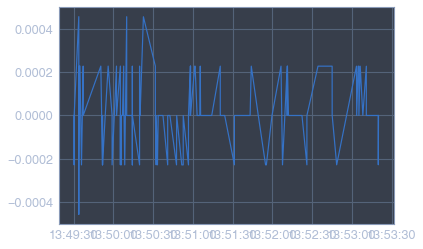

In [12]:
bk_last_logscale_shift = bk_last_logscale - bk_last_logscale.shift()
bk_last_logscale_shift.dropna(inplace=True)
plt.plot(bk_last_logscale_shift)

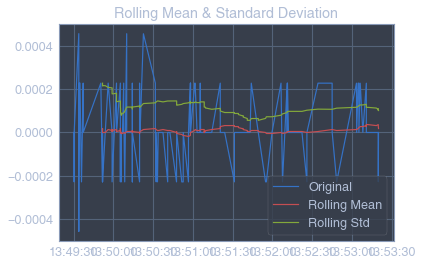

Results of Dickey-Fuller Test:
Test Statistic                                             -5.249116
p-value                                                     0.000007
#Lags Used                                                      10.0
Number of Observations Used                                    288.0
Critical Value 1%                                          -3.453262
Critical Value 5%                                          -2.871628
Critical Value 10%                                         -2.572146
RESULT:                        Reject Ho - Time Series is Stationary
dtype: object


In [13]:
test_stationary(bk_last_logscale_shift)

f:\python\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


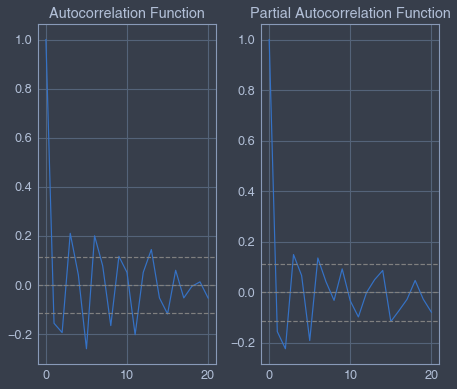

In [75]:
lag_acf = acf(bk_last_logscale_shift, nlags=20)
lag_pacf = pacf(bk_last_logscale_shift, nlags=20, method='ols')

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(bk_last_logscale_shift)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(bk_last_logscale_shift)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(bk_last_logscale_shift)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(bk_last_logscale_shift)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

f:\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
f:\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Plotting AR model


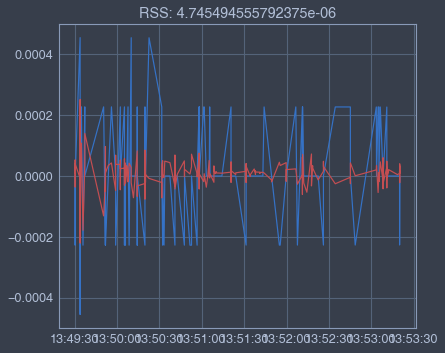

In [61]:
model = ARIMA(bk_last_logscale, order=(2, 1, 2))
results_AR = model.fit(disp=-1)
plt.plot(bk_last_logscale_shift)
plt.plot(results_AR.fittedvalues, color='r')
ser = (results_AR.fittedvalues - bk_last_logscale_shift)**2
plt.title(f'RSS: { ser.sum() }')
print('Plotting AR model')

In [62]:
results_AR.fittedvalues

Time
2023-04-24 13:49:30.422    0.000010
2023-04-24 13:49:30.422    0.000011
2023-04-24 13:49:30.422    0.000050
2023-04-24 13:49:30.422    0.000053
2023-04-24 13:49:30.422   -0.000036
                             ...   
2023-04-24 13:53:20.018    0.000035
2023-04-24 13:53:20.018    0.000040
2023-04-24 13:53:20.018   -0.000022
2023-04-24 13:53:20.018    0.000012
2023-04-24 13:53:20.092    0.000033
Length: 299, dtype: float64

In [63]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Time
2023-04-24 13:49:30.422    0.000010
2023-04-24 13:49:30.422    0.000011
2023-04-24 13:49:30.422    0.000050
2023-04-24 13:49:30.422    0.000053
2023-04-24 13:49:30.422   -0.000036
                             ...   
2023-04-24 13:53:20.018    0.000035
2023-04-24 13:53:20.018    0.000040
2023-04-24 13:53:20.018   -0.000022
2023-04-24 13:53:20.018    0.000012
2023-04-24 13:53:20.092    0.000033
Length: 299, dtype: float64


In [64]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Time
2023-04-24 13:49:30.422    0.000010
2023-04-24 13:49:30.422    0.000021
2023-04-24 13:49:30.422    0.000071
2023-04-24 13:49:30.422    0.000124
2023-04-24 13:49:30.422    0.000087
dtype: float64

In [65]:
predictions_ARIMA_log = pd.Series(bk_last_logscale[0], bk_last_logscale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Time
2023-04-24 13:49:30.078    3.782370
2023-04-24 13:49:30.422    3.782380
2023-04-24 13:49:30.422    3.782391
2023-04-24 13:49:30.422    3.782441
2023-04-24 13:49:30.422    3.782494
dtype: float64

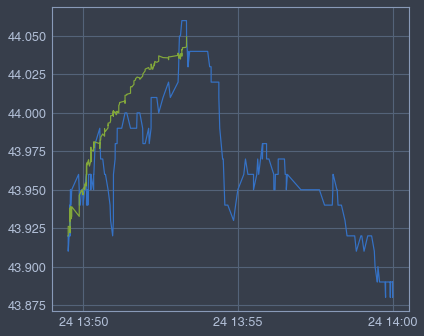

In [66]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(bk_df['Last'][300:800])
plt.plot(predictions_ARIMA)

f:\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
f:\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
f:\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


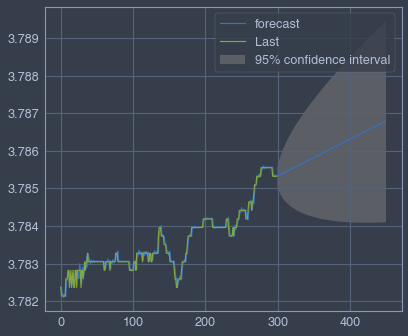

In [69]:
results_ARIMA.plot_predict(1, 450)
x = results_ARIMA.forecast(steps=120)

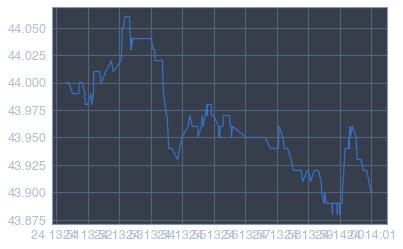

In [38]:
plt.plot(bk_df['Last'][500:900])

In [54]:
x[1]

array([0.00012585, 0.00016887, 0.00019461, 0.00022829, 0.00025651,
       0.00027504, 0.00029766, 0.00032046, 0.00033652, 0.000354  ,
       0.00037332, 0.00038815, 0.00040276, 0.00041945, 0.00043345,
       0.00044636, 0.000461  , 0.00047427, 0.00048612, 0.00049915,
       0.00051172, 0.00052287, 0.00053467, 0.00054652, 0.00055718,
       0.00056804, 0.00057919, 0.00058946, 0.0005996 , 0.0006101 ,
       0.00062001, 0.00062962, 0.00063953, 0.0006491 , 0.00065829,
       0.00066767, 0.0006769 , 0.00068576, 0.0006947 , 0.0007036 ,
       0.00071217, 0.00072073, 0.00072931, 0.00073762, 0.00074586,
       0.00075413, 0.00076222, 0.00077018, 0.00077817, 0.00078604,
       0.00079377, 0.0008015 , 0.00080915, 0.00081667, 0.00082417,
       0.00083161, 0.00083894, 0.00084623, 0.00085349, 0.00086064,
       0.00086774, 0.00087481, 0.0008818 , 0.00088873, 0.00089563,
       0.00090246, 0.00090923, 0.00091597, 0.00092266, 0.00092929,
       0.00093588, 0.00094243, 0.00094892, 0.00095537, 0.00096

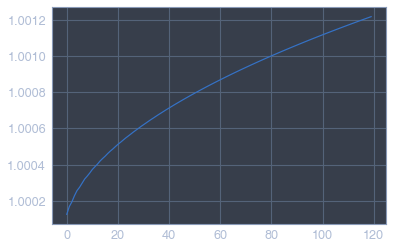

In [53]:
plt.plot(np.exp(x[1]))